# Рекомендация тарифов

# Введение

### Описание проекта 
Проект нацелен на то, чтобы разработать систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф.
### Цель проекта
Построить модель для задачи классификации, которая сможет определить подходящий тариф с точностью не менее 0.75.
### Описание данных
**В нашем распоряжении данные о поведении клиентов, которые уже перешли на тарифы «Ультра» и «Смарт».**  

В таблице представлены следующие данные:
- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

### План работы
1. Изучение общей информации о данных
2. Разбивка данных на выборки
  - Создание выборки для тренировки
  - Создание валидационной выборки
  - Создание тестовой выборки
3. Исследование моделей
  - Модель дерева принятия решений
  - Модель рандомного леса
  - Модель логистической регрессии
4. Проверка моделей на тестовой выборке
5. Проверка моделей на адекватность
6. Общий вывод

## Откройте и изучите файл

Импортируем необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import HalvingRandomSearchCV

Запишем датасет в переменную.

In [2]:
try:
    df = pd.read_csv('/datasets/users_behavior.csv')
except:
    df = pd.read_csv(r'D:\projects_data\users_behavior.csv')

Выведем общую информацию о таблице.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
# Код ревьюера
df['is_ultra'].value_counts()

0    2229
1     985
Name: is_ultra, dtype: int64

Посмотрим, какая часть пользователей пользуется тарифом «Ультра».

In [5]:
print('Доля пользователей с тарифом «Ультра» составляет:', round(df['is_ultra'].mean()*100, 2),'%')

Доля пользователей с тарифом «Ультра» составляет: 30.65 %


## Деление датасета на выборки

Подготовим признаки и целевые значения.

In [6]:
features = df.drop('is_ultra', axis=1)
target = df['is_ultra']

Разделим датасет на выборки в пропорциях 50%, 25% и 25%, где 50% займет выборка для обучения моделей (`train`), а по 25% будут иметь валидационная (`valid`) и тестовая (`test`) выборки.

In [7]:
features_train, f_test, target_train, t_test = \
train_test_split(features, target, test_size=0.5, random_state=1)

features_valid, features_test, target_valid, target_test = \
train_test_split(f_test, t_test, test_size=0.5, random_state=1)

In [8]:
# Код ревьюера
display(features_train.shape)
display(features_valid.shape)
display(features_test.shape)

(1607, 4)

(803, 4)

(804, 4)

## Исследование моделей

### Исследуем модель дерева принятия решений, изменяя гиперпараметр глубины дерева

In [9]:
best_model = None
best_accuracy = 0
result_tree = {}
for depth in range(1,10):
    model = DecisionTreeClassifier(random_state=1, max_depth = depth)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    accuracy = accuracy_score(target_valid, predictions_valid)
    result_tree[depth] = accuracy
    if accuracy > best_accuracy:
        optimal_depth = depth
        best_accuracy = accuracy
        best_tree_model = model
print(f'Лучшая модель с глубиной = {optimal_depth}, точность: {best_accuracy}')

Лучшая модель с глубиной = 4, точность: 0.7957658779576587


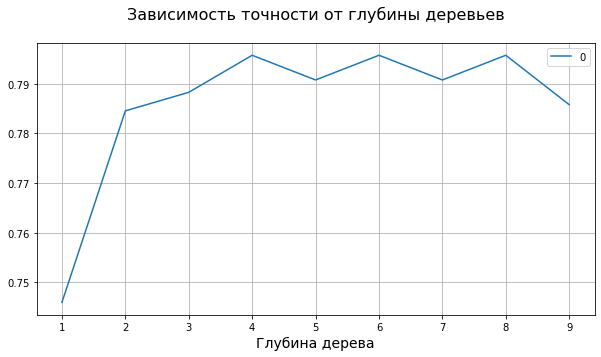

In [10]:
pd.DataFrame.from_dict(result_tree, orient='index').plot(grid=True, figsize=(10,5))
plt.title('Зависимость точности от глубины деревьев'+"\n", size = 16)
plt.xlabel('Глубина дерева', size=14)
plt.show()

Как мы видим глубина 1 не превышает заданный условием порог в 0.75, а с глубины равной 2 и далее точность колеблется примерно на одном, удовлетворяющем условию, уровне.

### Исследуем модель рандомного леса, изменяя гиперпараметр количества оценщиков

In [11]:
best_model = None
best_accuracy = 0
result_forest = {}

for est in range(1, 52, 5):
    model = RandomForestClassifier(random_state=1, n_estimators = est)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    accuracy = accuracy_score(target_valid, predictions_valid)
    result_forest[est] = accuracy
    if accuracy > best_accuracy:
        optimal_est = est
        best_accuracy = accuracy
        best_forest_model = model
print(f'Лучшая модель с количеством оценщиков = {optimal_est}, точность: {best_accuracy}')

Лучшая модель с количеством оценщиков = 36, точность: 0.8032378580323786


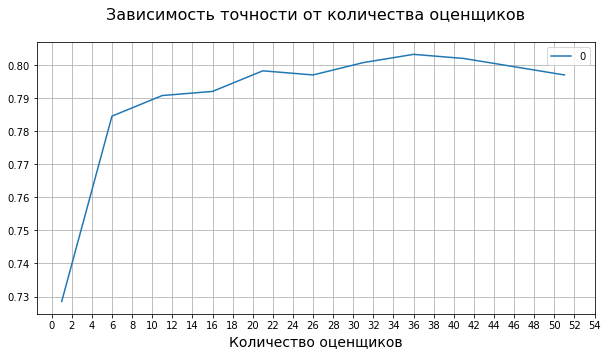

In [12]:
pd.DataFrame.from_dict(result_forest, orient='index').plot(grid=True, figsize=(10,5))
plt.title('Зависимость точности от количества оценщиков'+"\n", size = 16)
plt.xlabel('Количество оценщиков', size=14)
plt.xticks(np.arange(0, 55, 2))
plt.show()

На графике видно, что требуемая точность достигается уже при количестве оценщиков равном 3, а затем выходит на плато 0.79-0.80.

### Исследуем модель логистической регрессии

In [13]:
log_model = LogisticRegression(random_state=1)
log_model.fit(features_train, target_train)
result = log_model.predict(features_valid)
accuracy = accuracy_score(target_valid,result)
print('Точность модели логистической регрессии равна:', accuracy)

Точность модели логистической регрессии равна: 0.7471980074719801


Точность данной модели ниже порогового значения.

### Исследование модели рандомного леса с использованием RandomizedSearchCV

Воспользуемся алгоритмом RandomizedSearchCV для подбора наилучших гиперпараметров модели.

In [14]:
rf_grid = {'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 50, num = 10)],
           'max_features': ['auto', 'sqrt'],
           'max_depth': [int(x) for x in np.linspace(3, 33, num = 11)],
           'min_samples_split': [2, 5, 10],
           'min_samples_leaf': [1, 2, 4]}

model = RandomizedSearchCV(estimator = RandomForestClassifier(random_state=1), 
                   param_distributions = rf_grid, 
                   cv = 5, n_iter = 10)

model.fit(features_train, target_train)
result = model.predict(features_valid)

print('Точность модели рандомного леса с использованием алгоритма подбора гиперпараметров равна:', 
      accuracy_score(target_valid, result))

Точность модели рандомного леса с использованием алгоритма подбора гиперпараметров равна: 0.7945205479452054


### Исследование модели рандомного леса с использованием HalvingGridSearchCV

In [15]:
rf_grid = {'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 50, num = 10)],
           'max_features': ['auto', 'sqrt'],
           'max_depth': [int(x) for x in np.linspace(3, 33, num = 11)],
           'min_samples_split': [2, 5, 10],
           'min_samples_leaf': [1, 2, 4]}

model = HalvingGridSearchCV(RandomForestClassifier(random_state=1), 
                            rf_grid, 
                            scoring="accuracy", 
                            n_jobs=-1, 
                            min_resources="exhaust", 
                            factor=3)
for i in range(3):
    model.fit(features_train, target_train)
    print(model.best_params_)
    result = model.predict(features_valid)
    print('Точность модели рандомного леса с использованием алгоритма HalvingGridSearchCV равна:', 
          accuracy_score(target_valid, result))

{'max_depth': 6, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}
Точность модели рандомного леса с использованием алгоритма HalvingGridSearchCV равна: 0.8032378580323786
{'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 18}
Точность модели рандомного леса с использованием алгоритма HalvingGridSearchCV равна: 0.7858032378580324
{'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 18}
Точность модели рандомного леса с использованием алгоритма HalvingGridSearchCV равна: 0.7858032378580324


### Исследование модели рандомного леса с использованием HalvingRandomSearchCV

In [16]:
rf_grid = {'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 50, num = 10)],
           'max_features': ['auto', 'sqrt'],
           'max_depth': [int(x) for x in np.linspace(3, 33, num = 11)],
           'min_samples_split': [2, 5, 10],
           'min_samples_leaf': [1, 2, 4]}

model = HalvingRandomSearchCV(RandomForestClassifier(random_state=0), 
                               rf_grid, 
                               random_state=0)
for i in range(3):
    model.fit(features_train, target_train)
    print(model.best_params_)
    result = model.predict(features_valid)
    print('Точность модели рандомного леса с использованием алгоритма HalvingRandomSearchCV равна:', 
            accuracy_score(target_valid, result))

{'n_estimators': 36, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 3}
Точность модели рандомного леса с использованием алгоритма HalvingRandomSearchCV равна: 0.788293897882939
{'n_estimators': 36, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 3}
Точность модели рандомного леса с использованием алгоритма HalvingRandomSearchCV равна: 0.788293897882939
{'n_estimators': 36, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 3}
Точность модели рандомного леса с использованием алгоритма HalvingRandomSearchCV равна: 0.788293897882939


**После сравнения показателей точности выяснилось, что наибольшей точностью обладает модель, в которой использовался алгоритм RandomForestClassifier. Следовательно, целесообразно выбрать именно эту модель для проверки на тестовой выборке.**

## Проверка модели на тестовой выборке

**Проверка модели на основе RandomForestClassifier с количеством оценщиков = 36 .**

In [17]:
result = best_forest_model.predict(features_test)
print('Точность модели на тестовой выборке равна:', accuracy_score(target_test, result))

Точность модели на тестовой выборке равна: 0.7935323383084577


**На тестовой выборке модель показала точность 0.79, что удовлетворяет условию исследования о пороге точности.**

## Проверка модели на адекватность

Чтобы проверить адекватность исследования, произведём сравнение модели рандомный лес с моделью, которая предлагает самый часто встречающийся вариант целевого параметра.

In [18]:
dummy_model = DummyClassifier(strategy="most_frequent")
dummy_model.fit(features_train, target_train)
result = dummy_model.predict(features_test)
dummy_accuracy = accuracy_score(target_test, result)
print('Точность простейшей модели равна:', dummy_accuracy)

Точность простейшей модели равна: 0.6791044776119403


**Результат сравнеия точности модели рандомного леса и простейшей модели говорит о том, что самая точная, из выбранных нами моделей, работает значительно лучше, чем если бы мы просто брали самое частое значение целевого параметра, следовательно, она выдаёт адекватные результаты.**

## Общий вывод

В ходе исследования были проанализированы данные о пользователях компании мобильной связи. Затем проведена подготовка выборок для создания моделей классификации пользователей по тарифным планам.   
Протестированы различные модели машинного обучения с разными настройками гиперпараметров.   
По итогу тестирования была определена наилучшая по точности модель, которая основана на алгоритме рандомного леса. На тестовой выборке данная модель показала результат, полностью соответсвующий цели исследования. Точность выбранной модели значительно превышает результат простейшей модели, что говорит о целесообразности её применения.